In [4]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [113]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [114]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

In [115]:
#################
### PROBLEM 1 ###
#################

def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of binary labels shape = (n, 1)
    :return entropy: entropy value
    '''
    # Your code goes here
   
    zero_vals = 0
    one_vals = 0
    n = len(label_array)
    for label in label_array:
        if label == 0:
            zero_vals += 1
        elif label == 1:
            one_vals += 1


    if zero_vals == 0 or one_vals == 0:
        return 0

    class_0 = ((zero_vals) / (n)) * np.log2((zero_vals) / (n))
    class_1 = ((one_vals) / (n)) * np.log2((one_vals) / (n))

    return class_0 + class_1



def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    # Your code goes here
    zero_vals = 0
    one_vals = 0
    n = len(label_array)
    for label in label_array:
        if label == 0:
            zero_vals += 1
        elif label == 1:
            one_vals += 1

    gini0 = ((zero_vals) / (n))
    gini1 = ((one_vals) / (n))

    gini = 1 - ((gini0 ** 2) + (gini1 ** 2))

    return gini

In [116]:
#################
### PROBLEM 2 ###
#################

class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args (X, y) returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = False

    def fit(self, x, y):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        # Your code goes here

        ## Define base case 
        num_samples = len(y)

        # Initialize self split ID and split value 
        self.find_best_feature_split(x, y)

        # If we've hit max depth or eclipsed min samples
        if self.depth >= self.max_depth or self.min_sample >= num_samples:
            self.is_leaf = True 
            self.value = self.leaf_value_estimator(y)
            return self 
       
        ## Otherwise, we continue with our method
        
        # Depth that we will reach on next recurse
        next_depth = self.depth + 1

        ## Recurse on the left node         
        # Init self.left Decision_Tree Object using the same params as self
        self.left = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, next_depth, self.min_sample, self.max_depth)

        # Get records that did not meet split value
        left_mask = (x[:, self.split_id] <= self.split_value)
        left_rows = x[left_mask, :]

        left_labels = y[left_mask, :]

        ## Recurse on the right node         
        # Init self.right Decision_Tree Object using the same params as self
        self.right = Decision_Tree(self.split_loss_function, self.leaf_value_estimator, next_depth, self.min_sample, self.max_depth)

        # Get records that did not meet split value
        right_mask = (x[:, self.split_id] > self.split_value)
        right_rows = x[right_mask, :]

        right_labels = y[right_mask, :]

        print('Depth :', self.depth, 'Left Len :', len(left_labels), 'Right Len :', len(right_labels), 'Split ID: ', self.split_id, 'Split Value: ', self.split_value)

        if len(left_labels) < 1 or len(right_labels) < 1:
            self.is_leaf = True 
            self.value = self.leaf_value_estimator(y)
            return self 

        # Recurse Fit Left
        self.left.fit(left_rows, left_labels)

        # Recurse Fit Right
        self.right.fit(right_rows, right_labels)

        return self

    def find_best_split(self, x_node, y_node, feature_id):
        '''
        For feature number feature_id, returns the optimal splitting point 
        for data X_node, y_node, and corresponding loss
        :param X: a numpy array of training data, shape = (n_node)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        # Your code

        # Initialize the loss to beat and split value
        best_loss = self.split_loss_function(y_node)
        best_split_val = 0

        # Set up loop through all possible data points
        n_features = len(y_node)

        # Set up data for specified feature id 
        x_node = x_node[:,feature_id]

        # Sort x and y points
        sort_idx = x_node.argsort()
        
        x_node = x_node[sort_idx]
        y_node = y_node[sort_idx]

        for i in range(n_features - 1):
            if x_node[i] == x_node[i+1]:
                continue

            # Get midpoint to split on 
            midpoint_split = np.mean(x_node[i: i+1])

            # Define left and right nodes 
            left_rows = x_node[x_node <= midpoint_split]
            right_rows = x_node[x_node > midpoint_split]

            # Define left and right labels 
            left_labels = y_node[x_node <= midpoint_split]
            right_labels = y_node[x_node > midpoint_split]

            # Extract loss 
            left_loss = self.split_loss_function(left_labels)
            right_loss = self.split_loss_function(right_labels)

            # Compute Combined Impurity 
            combined_loss = (len(left_labels) * left_loss + len(right_labels) * right_loss) / n_features

            if combined_loss <= best_loss:
                best_loss = combined_loss
                best_split_val = midpoint_split

        return best_split_val, best_loss

    def find_best_feature_split(self, x_node, y_node):
        '''
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        :param X: a numpy array of training data, shape = (n_node, 1)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''

        # Your code

        num_features = x_node.shape[1]

        loss_to_beat = 10000000000
        best_ind = -1
        best_split_val_param = -1
        for i in range(num_features):
            best_split_val, best_loss = self.find_best_split(x_node,y_node, i)

            if best_loss <= loss_to_beat:
                loss_to_beat = best_loss
                best_ind = i
                best_split_val_param = best_split_val
        
        self.split_id = best_ind
        self.split_value = best_split_val_param
        

    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

In [117]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [118]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Decision Tree Boundary

Depth : 0 Left Len : 107 Right Len : 93 Split ID:  1 Split Value:  0
Depth : 0 Left Len : 107 Right Len : 93 Split ID:  1 Split Value:  0
Depth : 1 Left Len : 107 Right Len : 0 Split ID:  1 Split Value:  0
Depth : 1 Left Len : 0 Right Len : 93 Split ID:  1 Split Value:  0
Depth : 0 Left Len : 107 Right Len : 93 Split ID:  1 Split Value:  0
Depth : 1 Left Len : 107 Right Len : 0 Split ID:  1 Split Value:  0
Depth : 1 Left Len : 0 Right Len : 93 Split ID:  1 Split Value:  0
Depth : 0 Left Len : 107 Right Len : 93 Split ID:  1 Split Value:  0
Depth : 1 Left Len : 107 Right Len : 0 Split ID:  1 Split Value:  0
Depth : 1 Left Len : 0 Right Len : 93 Split ID:  1 Split Value:  0
Depth : 0 Left Len : 107 Right Len : 93 Split ID:  1 Split Value:  0
Depth : 1 Left Len : 107 Right Len : 0 Split ID:  1 Split Value:  0
Depth : 1 Left Len : 0 Right Len : 93 Split ID:  1 Split Value:  0
Depth : 0 Left Len : 107 Right Len : 93 Split ID:  1 Split Value:  0
Depth : 1 Left Len : 107 Right Len : 0 Split I

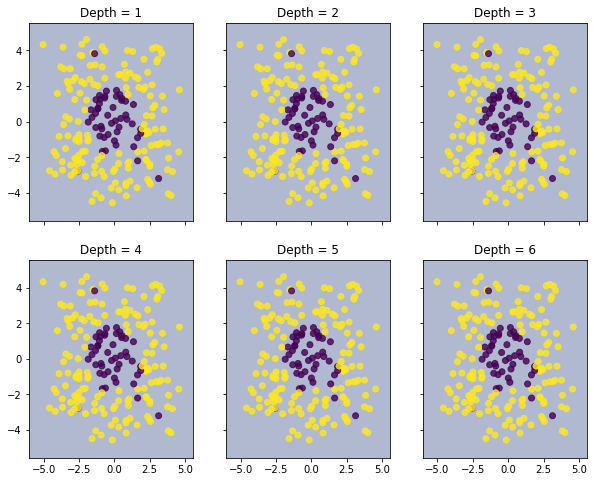

In [119]:
#################
### PROBLEM 3 ###
#################

# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [120]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

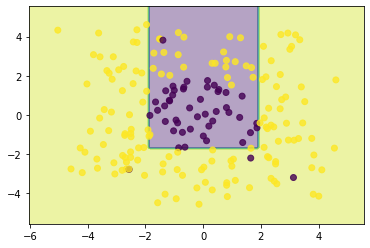

In [121]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c=y_train_label[:,0], alpha=0.8)

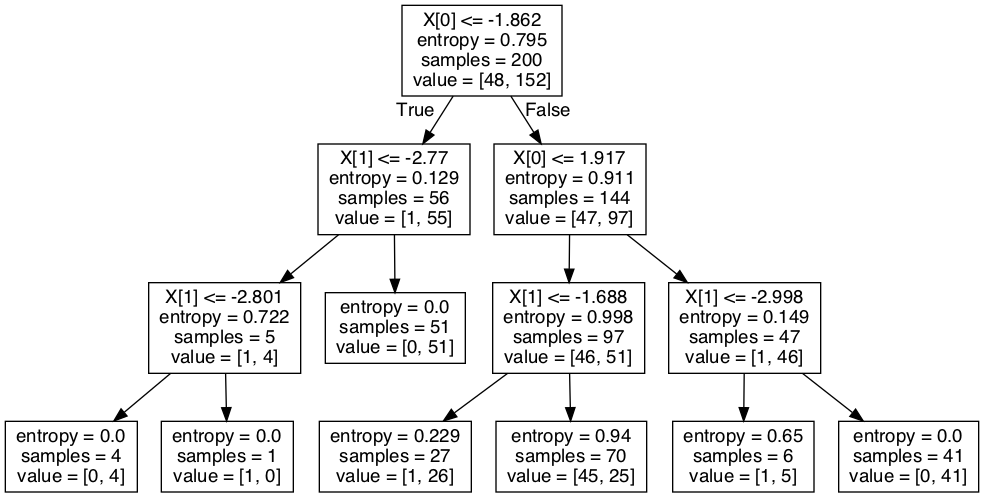

In [122]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png
Image(filename='tree_classifier.png')

# Decision Tree Regressor

In [123]:
#################
### PROBLEM 4 ###
#################

# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    # Your code goes here
   

    true_median = np.median(y)
    deviation = 0
    for val in y:
        deviation += abs(true_median - val)

    mae = deviation

    return mae

In [124]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

Depth : 0 Left Len : 70 Right Len : 30 Split ID:  0 Split Value:  0.6666817103568048
Depth : 0 Left Len : 70 Right Len : 30 Split ID:  0 Split Value:  0.6666817103568048
Depth : 1 Left Len : 30 Right Len : 40 Split ID:  0 Split Value:  0.25097502280875694
Depth : 1 Left Len : 8 Right Len : 22 Split ID:  0 Split Value:  0.7401460972315151
Depth : 0 Left Len : 70 Right Len : 30 Split ID:  0 Split Value:  0.6666817103568048
Depth : 1 Left Len : 30 Right Len : 40 Split ID:  0 Split Value:  0.25097502280875694
Depth : 2 Left Len : 15 Right Len : 15 Split ID:  0 Split Value:  0.16753208021080218
Depth : 2 Left Len : 17 Right Len : 23 Split ID:  0 Split Value:  0.40913763201667286
Depth : 1 Left Len : 8 Right Len : 22 Split ID:  0 Split Value:  0.7401460972315151
Depth : 2 Left Len : 4 Right Len : 4 Split ID:  0 Split Value:  0.7016430038138347
Depth : 2 Left Len : 12 Right Len : 10 Split ID:  0 Split Value:  0.8748274820581425
Depth : 0 Left Len : 70 Right Len : 30 Split ID:  0 Split Value: 

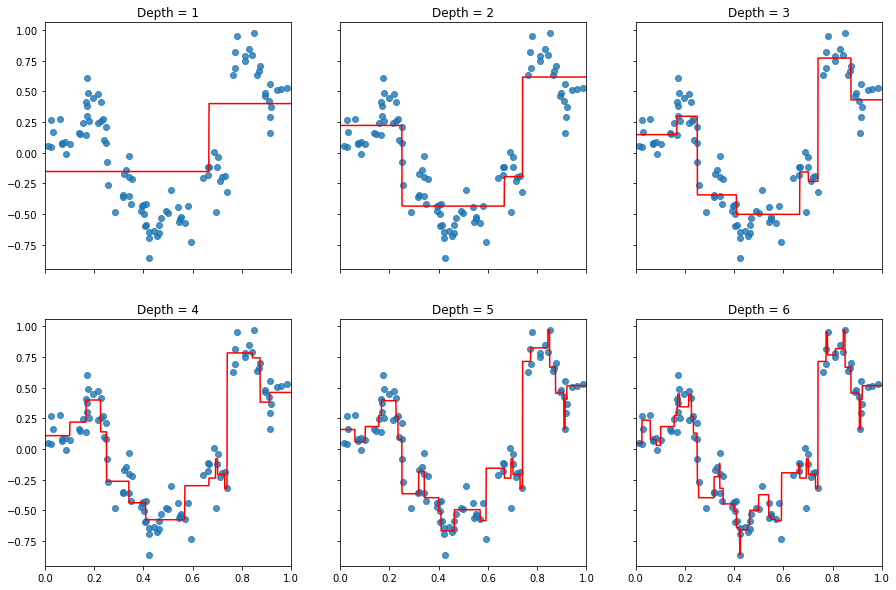

In [125]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='mean')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='mean')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='mean')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='mean')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='mean')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='mean')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Compare with scikit-learn for debugging

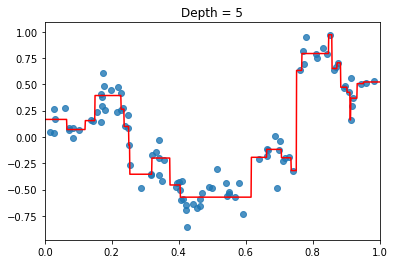

In [322]:
# DecisionTreeRegressor(criterion=, max_depth=, min_samples_split=)


# Gradient Boosting Method

In [128]:
#Pseudo-residual function.

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [224]:
#################
### PROBLEM 5 ###
#################

class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01, 
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth

        self.estimators = [] #will collect the n_estimator models
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, m_features) 
        :train_target array of outputs of size (n_samples,) 
        '''
        # Your code goes here 

        ## To collect the n_estimator models
        estimators_list = []

        ## Model so that we can run our first iteration
        base_model = DecisionTreeRegressor(criterion='squared_error', max_depth = self.max_depth, min_samples_split = self.min_sample)
        base_model.fit(train_data, train_target)

        ## For n estimators 
        for i in range(self.n_estimator):
            ## Step 1: Compute Psuedo Residuals
            y_preds = base_model.predict(train_data)
            # For squared loss, the psuedo residuals are the residuals 
            residuals = train_target - y_preds 

            ## Step 2: Fit base learning hm with squared loss 
            base_model = DecisionTreeRegressor(criterion='squared_error', max_depth = self.max_depth, min_samples_split = self.min_sample)
            base_model.fit(train_data, residuals)

            estimators_list.append(base_model)
            
        self.estimators = estimators_list
        
        return self
    
    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, m_features)
        '''
        # Your code goes here

        ## Step 3: Update fm = fm-1 + (lr * vm * hm)
        lr = self.learning_rate

        for i in range(self.n_estimator):
            model = self.estimators[i]            
            if i == 0:
                val = lr * (model.predict(test_data))
            else:
                val += lr * (model.predict(test_data))

        test_predict = val 
        return test_predict


# 1-D GBM visualization - KRR data

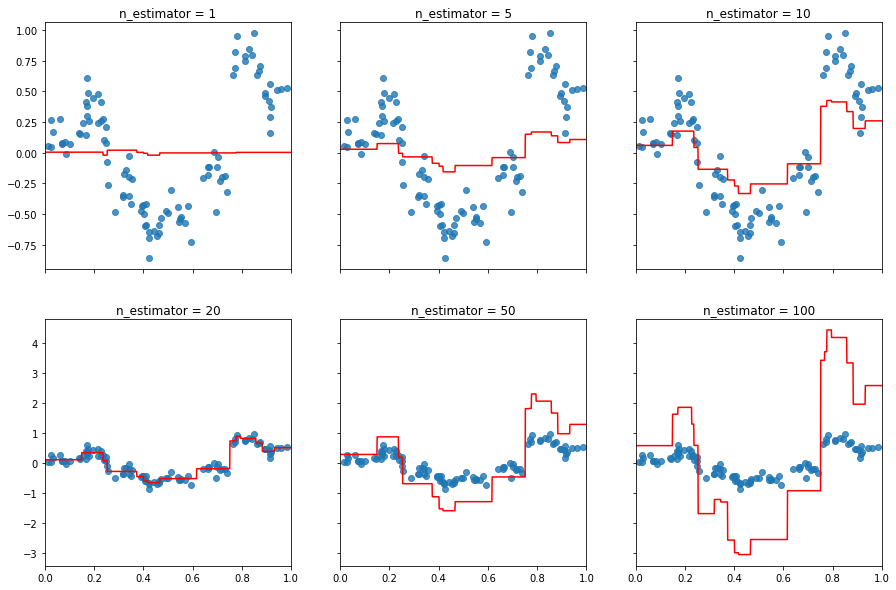

In [226]:
#################
### PROBLEM 6 ###
#################

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

# Sklearn implementation for Classification of images

In [227]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

In [228]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    indicator_01 = (y_mnist == '0') + (y_mnist == '1') 
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [229]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

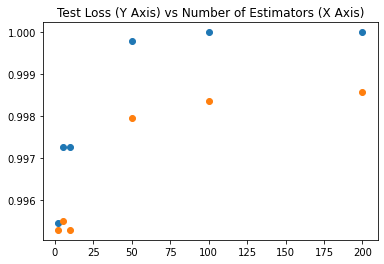

In [240]:
#################
### PROBLEM 9 ###
#################

train_losses = []
test_losses = []

estimator_params = [2,5,10,50,100,200]
for n_estimator in estimator_params:
    clf = GradientBoostingClassifier(loss='deviance', n_estimators=n_estimator, max_depth=3, random_state=0).fit(X_train, y_train)
    train_loss = clf.score(X_train, y_train)
    test_loss = clf.score(X_test, y_test)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.scatter(estimator_params, train_losses, label = 'train')
plt.title('Train Loss (Y Axis) vs Number of Estimators (X Axis)')

plt.scatter(estimator_params, test_losses, label = 'test')
plt.title('Test Loss (Y Axis) vs Number of Estimators (X Axis)')
plt.show()

### Problem 10 

In general, Random Forests employ the power of many uncorrelated trees in order to generate more accurate predictions than a single decision tree. As a parameter, the Random Forest model is told how many trees to construct. Each tree is given a random subset of features (this is the "random" in Random Forest) in order to ensure that the trees are uncorrelated. Then, each tree is treated as its own independent decision tree and the collection of decisions is used in order to generate a prediction based on the input. Notably, in addition to classification the Random Forest model can also be used for regression the same way a decision tree can also be used for regression. 

Random Forests employ the same ideas of entropy and gini as individual decision trees; the key difference with the Random Forest is the use of uncorrelated trees in order to generate a "forest." 

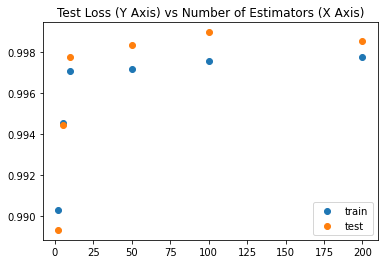

In [239]:
#################
### PROBLEM 11 ###
#################

train_losses = []
test_losses = []

estimator_params = [2,5,10,50,100,200]
for n_estimator in estimator_params:
    clf = clf = RandomForestClassifier(criterion = 'entropy', n_estimators = n_estimator, max_depth = 3).fit(X_train, y_train)
    train_loss = clf.score(X_train, y_train)
    test_loss = clf.score(X_test, y_test)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.scatter(estimator_params, train_losses, label = 'train')
plt.title('Train Loss (Y Axis) vs Number of Estimators (X Axis)')

plt.scatter(estimator_params, test_losses, label = 'test')
plt.title('Test Loss (Y Axis) vs Number of Estimators (X Axis)')
plt.legend()

plt.show()

### PROBLEM 12

It appears that the Random Forest Classifier is less prone to overfitting as it generalizes better for the test set. This makes sense given the utilization of many uncorrelated trees; in fact, this is a noted benefit of using the Random Forest Classifier and is an attribute of it that makes it popular to use. 

While the Gradient Boosted Trees outperform Random Forest Classifier on the train accuracy, the Random Forest Classifier has a higher accuracy for the test set. This is expected as the Random Forest Classifier is designed with the intent of superior generalizaton. Pragmatically, using the model that performs better for the train accuracy could result in poor predictions in the future (even though it retroactively performs well). 